<a href="https://colab.research.google.com/github/shekarroy15/Our-Capstone-Project/blob/main/state%20of%20the%20art%20models/Roboflow_Train_YOLOv5_Updated_Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: This colab notebook has been processed on a local instance, i.e. an AWS EC2 instance in place of the Colab's default instance*

# Local EC2 host config

In [1]:
%cd /content
%ls

/content


# Clone YOLOv5 gitrepo

In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
# !git reset --hard 4effd064b169fc049b4a4bca401b120bf2e93c14

Cloning into 'yolov5'...
remote: Enumerating objects: 12180, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 12180 (delta 6), reused 13 (delta 4), pack-reused 12160
Receiving objects: 100% (12180/12180), 11.46 MiB | 34.02 MiB/s, done.
Resolving deltas: 100% (8455/8455), done.
/content/yolov5


#Install Dependencies

In [3]:
!pip install -qr requirements.txt

In [4]:
import torch
from IPython.display import Image  # to display images
from utils.downloads import gdrive_download  # to download models/datasets

In [8]:
print(f'torch version: {torch.__version__}')
print(f"GPU details:\n{torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'}")

torch version: 1.10.1+cu102
GPU details:
_CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16160MB, multi_processor_count=80)


# Download Correctly Formatted Custom Dataset

In [9]:
!pip install -q roboflow

In [10]:
%cd /content/yolov5
from roboflow import Roboflow
rf = Roboflow(api_key="DWd8peTmhPvFfBvj5bmx")
project = rf.workspace("sudharsan-rengarajan").project("capstone-g7-car-detection")
dataset = project.version(3).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to capstone-g7-car-detection-3 in yolov5pytorch:: 100%|██████████| 57948/57948 [00:07<00:00, 7634.86it/s]


In [11]:
# Roboflow YOLOv5 data YAML file
%cat {dataset.location}/data.yaml

names:
- AM General Hummer SUV 2000
- Acura Integra Type R 2001
- Acura RL Sedan 2012
- Acura TL Sedan 2012
- Acura TL Type-S 2008
- Acura TSX Sedan 2012
- Acura ZDX Hatchback 2012
- Aston Martin V8 Vantage Convertible 2012
- Aston Martin V8 Vantage Coupe 2012
- Aston Martin Virage Convertible 2012
- Aston Martin Virage Coupe 2012
- Audi 100 Sedan 1994
- Audi 100 Wagon 1994
- Audi A5 Coupe 2012
- Audi R8 Coupe 2012
- Audi RS 4 Convertible 2008
- Audi S4 Sedan 2007
- Audi S4 Sedan 2012
- Audi S5 Convertible 2012
- Audi S5 Coupe 2012
- Audi S6 Sedan 2011
- Audi TT Hatchback 2011
- Audi TT RS Coupe 2012
- Audi TTS Coupe 2012
- Audi V8 Sedan 1994
- BMW 1 Series Convertible 2012
- BMW 1 Series Coupe 2012
- BMW 3 Series Sedan 2012
- BMW 3 Series Wagon 2012
- BMW 6 Series Convertible 2007
- BMW ActiveHybrid 5 Sedan 2012
- BMW M3 Coupe 2012
- BMW M5 Sedan 2010
- BMW M6 Convertible 2010
- BMW X3 SUV 2012
- BMW X5 SUV 2007
- BMW X6 SUV 2012
- BMW Z4 Convertible 2012
- Bentley Arnage Sedan 2009
-

# Define Model Configuration and Architecture

In [12]:
# Define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [13]:
# This is the model configuration
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [14]:
# Customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [15]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

Argument list:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs.
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [16]:
# train yolov5s on custom data and time its performance
%%time
%cd /content/yolov5/
!python3 train.py --img 416 --batch 32 --epochs 400 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/capstone-g7-car-detection-3/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=400, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/ultralytics/yolov5
   15d318a..4821e23  test/conv_reduction -> origin/test/conv_reduction
github:

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

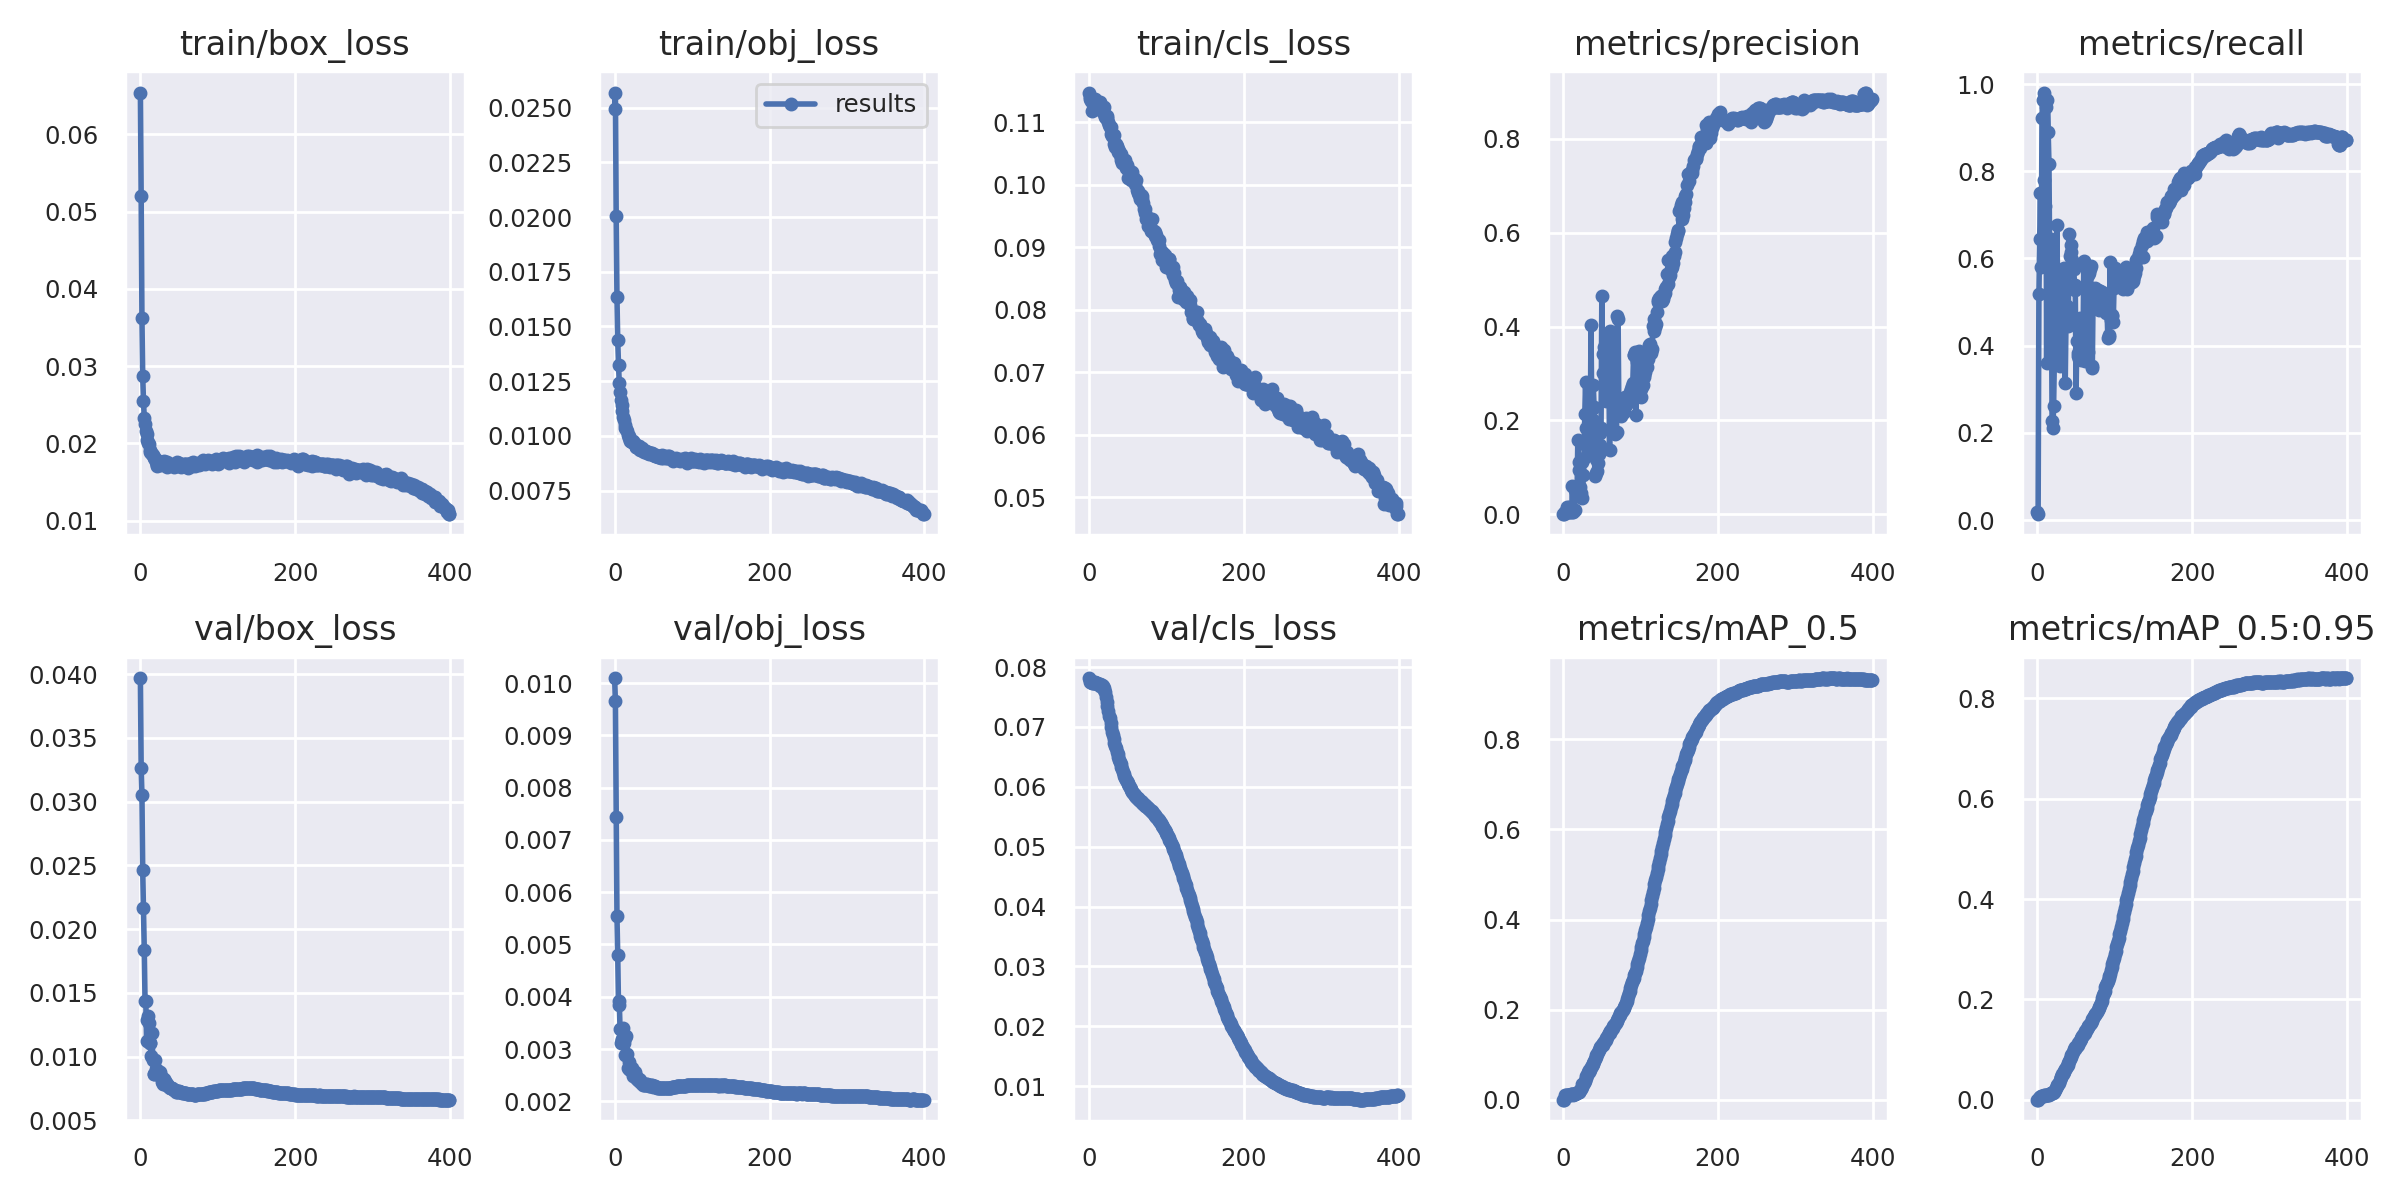

In [17]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [18]:
# List best weights saved
%ls /content/yolov5/runs/train/yolov5s_results/weights

best.pt  last.pt


In [19]:
# use the best weights!
%cd /content/yolov5/
!python3 detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source {dataset.location}/test/images

Streaming output truncated to the last 5000 lines.
image 3032/8029 /content/yolov5/capstone-g7-car-detection-3/test/images/03036_jpg.rf.fa807b8823c4eeffbb7b2893d7247d3f.jpg: 416x416 1 Chevrolet Impala Sedan 2007, Done. (0.009s)
image 3033/8029 /content/yolov5/capstone-g7-car-detection-3/test/images/03037_jpg.rf.327f60dc6e0c239ec797c06a93286412.jpg: 416x416 1 Rolls-Royce Ghost Sedan 2012, Done. (0.009s)
image 3034/8029 /content/yolov5/capstone-g7-car-detection-3/test/images/03038_jpg.rf.3bd49e30e02a50a7a1b062c459bad85a.jpg: 416x416 1 Mazda Tribute SUV 2011, Done. (0.008s)
image 3035/8029 /content/yolov5/capstone-g7-car-detection-3/test/images/03039_jpg.rf.030f4ab149241816ed182ee861fc7d38.jpg: 416x416 1 BMW M3 Coupe 2012, Done. (0.009s)
image 3036/8029 /content/yolov5/capstone-g7-car-detection-3/test/images/03040_jpg.rf.bbaac22c6895579849c27a3312eddf3f.jpg: 416x416 1 Daewoo Nubira Wagon 2002, Done. (0.009s)
image 3037/8029 /content/yolov5/capstone-g7-car-detection-3/test/images/03041_jpg

# Export Trained Weights for Future Inference

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#%cp /content/yolov5/runs/train/yolov5s_results2/weights/best.pt /content/drive/MyDrive/CAPSTONE_PROJECT/best_yolov5_25mar2022.pt

*Since this run is on an EC2 instance, to copy the file directly from there*